<a href="https://colab.research.google.com/github/hiddenntreasure/quora/blob/master/Cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Personalized cancer diagnosis**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


 <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>

In [5]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS 2: Personalized Cancer Diagnosis/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
data_text =pd.read_csv("/content/drive/My Drive/Colab Notebooks/CS 2: Personalized Cancer Diagnosis/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string
        # in pandas we can work on particular index/datapoint's column's like: dataframe[column first][row]

In [9]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 28.582033000000003 seconds


In [10]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
# loc [labels,needing column] = row's complete the labels

In [13]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


**3.1.4. Test, Train and Cross Validation Split**

In [0]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

x_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify =y_true, test_size=0.2)
#stratify used to maintain same distribution of output class 
train_df, cv_df, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

In [15]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [16]:
!pip install pandas -U

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)


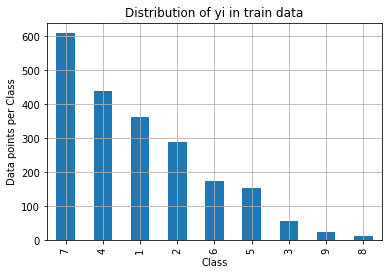

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


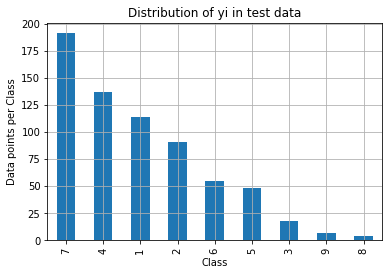

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


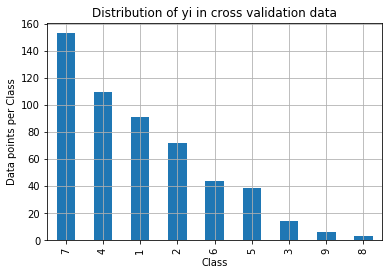

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [17]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


for i in train_class_distribution.index:
    print('Number of data points in class', i, ':',train_class_distribution[i], '(', np.round((train_class_distribution[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


for i in test_class_distribution.index:
    print('Number of data points in class', i, ':',test_class_distribution[i], '(', np.round((test_class_distribution[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


for i in cv_class_distribution.index:
    print('Number of data points in class', i, ':',cv_class_distribution[i], '(', np.round((cv_class_distribution[i]/cv_df.shape[0]*100), 3), '%)')


# Confusion matrix

In [0]:
def plot_confusion_matrix(test_y,predict_y):
  C = confusion_matrix(test_y,predict_y)
  #axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
  A = (((C.T)/(C.sum(axis=1))).T) #Recall: percentage of true class out of Total autual class
  B = (C/C.sum(axis=0)) #Precision: percentage of true class out of Total predicted class

  labels = [1,2,3,4,5,6,7,8,9]
  # representing A in heatmap format
  print("-"*20, "Confusion matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
    
  # representing B in heatmap format
  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()




In [19]:
x=np.random.rand(1,9)
print(x)
sum(x)

#One sum function can't sum up np values

[[0.80277469 0.54620609 0.61388464 0.05918809 0.50188036 0.20425196
  0.82035105 0.06492853 0.73434011]]


array([0.80277469, 0.54620609, 0.61388464, 0.05918809, 0.50188036,
       0.20425196, 0.82035105, 0.06492853, 0.73434011])

# Random' Model

CV log loss:- 2.4789774454365237
TEST log loss:- 2.4344282442985605
-------------------- Confusion matrix --------------------


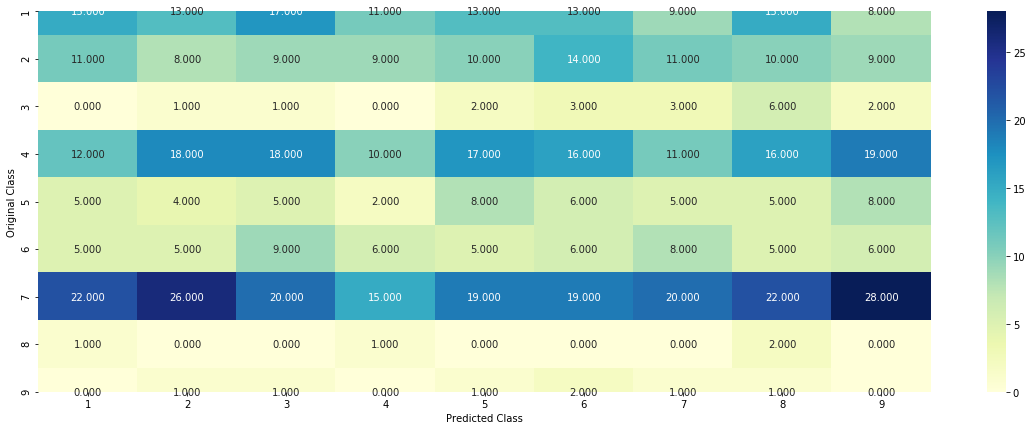

-------------------- Precision matrix (Columm Sum=1) --------------------


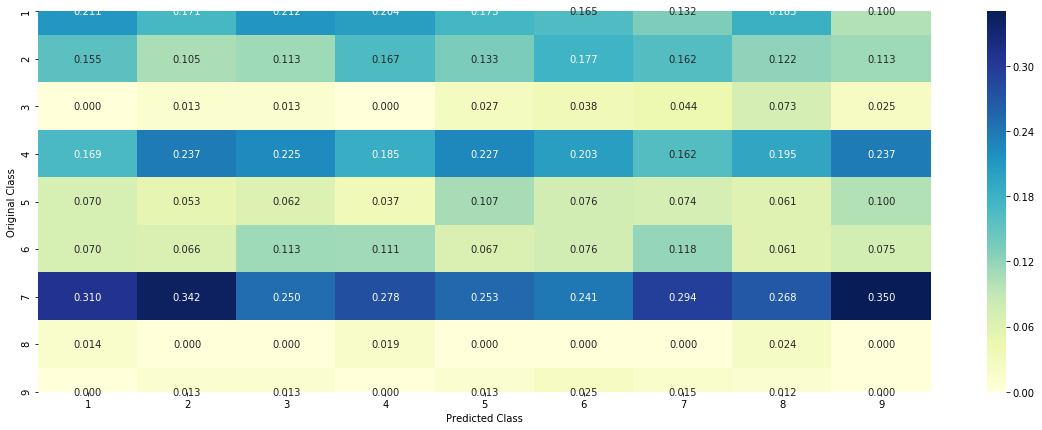

-------------------- Recall matrix (Row sum=1) --------------------


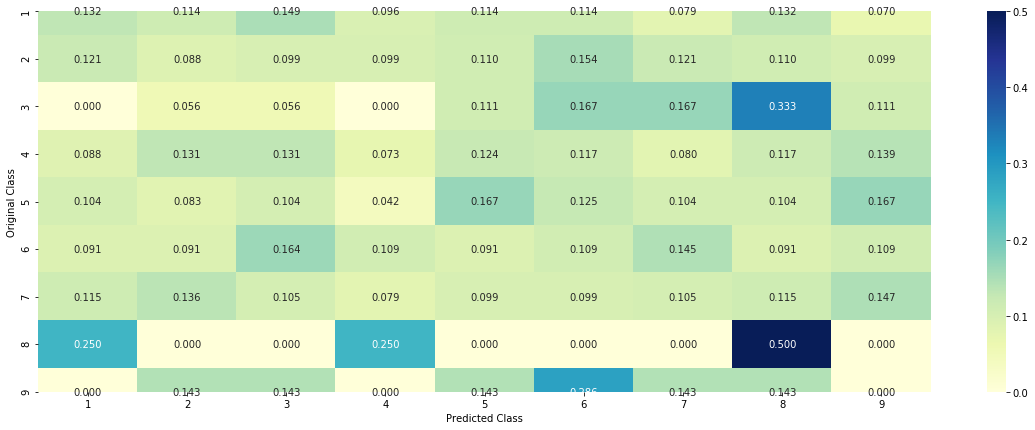

In [20]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
  rand_probs = np.random.rand(1,9)
  cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print('CV log loss:-' ,log_loss(y_cv,cv_predicted_y,eps=1e-15) )

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
  rand_probs = np.random.rand(1,9)
  test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print('TEST log loss:-' ,log_loss(y_test,test_predicted_y,eps=1e-15) )

predicted_y = np.argmax(test_predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y+1)


In [21]:
predicted_y

array([4, 3, 2, 7, 6, 7, 5, 2, 8, 8, 5, 5, 1, 7, 4, 2, 0, 2, 0, 5, 5, 2,
       3, 8, 6, 5, 8, 3, 1, 6, 3, 5, 7, 2, 8, 2, 7, 3, 1, 4, 2, 5, 2, 5,
       1, 7, 0, 4, 1, 2, 1, 4, 7, 3, 4, 5, 5, 4, 0, 3, 6, 4, 8, 1, 2, 3,
       7, 2, 8, 2, 2, 8, 6, 1, 1, 0, 4, 2, 7, 0, 8, 6, 0, 0, 1, 2, 4, 2,
       0, 7, 0, 4, 1, 0, 5, 0, 3, 2, 5, 5, 7, 8, 6, 7, 1, 0, 8, 2, 8, 8,
       5, 5, 1, 2, 5, 8, 7, 7, 1, 0, 1, 3, 2, 0, 5, 8, 7, 5, 3, 7, 4, 7,
       8, 0, 6, 8, 7, 4, 5, 5, 3, 8, 1, 8, 0, 6, 7, 4, 8, 6, 0, 0, 0, 0,
       3, 5, 7, 4, 8, 1, 5, 1, 7, 4, 6, 8, 2, 5, 0, 5, 7, 1, 2, 8, 1, 5,
       2, 4, 2, 2, 5, 7, 6, 8, 4, 3, 8, 8, 5, 1, 5, 4, 8, 4, 2, 1, 4, 1,
       1, 6, 2, 6, 4, 4, 6, 0, 0, 7, 6, 0, 4, 1, 4, 0, 7, 4, 4, 4, 4, 0,
       7, 8, 3, 0, 6, 4, 7, 7, 2, 2, 7, 1, 2, 0, 8, 3, 2, 4, 1, 6, 6, 3,
       4, 1, 7, 0, 4, 2, 1, 0, 8, 6, 8, 3, 1, 5, 3, 6, 1, 4, 7, 2, 4, 7,
       3, 4, 7, 3, 1, 5, 1, 2, 5, 2, 0, 0, 0, 6, 8, 6, 1, 8, 1, 7, 4, 1,
       7, 6, 6, 4, 8, 7, 3, 6, 2, 1, 0, 1, 7, 8, 5,

# 3.3 Univariate Analysis

In [0]:
def get_gv_fea_dict(alpha, feature, df):
  value_count = train_df[feature].value_counts()
   
  gv_dict = dict()
  for i, denominator in value_count.items(): # items() method is used to return the list with all dictionary keys with values.
    vec = []
    for k in range(1,10):
      cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
      #. DataFrame.loc[] method is a method that takes only index labels and returns row or dataframe if the index label exists in the caller data frame.
      vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
    gv_dict[i] = vec
  return gv_dict

def get_gv_feature(alpha,feature,df):
  gv_dict = get_gv_fea_dict(alpha, feature, df)

  value_count = train_df[feature].value_counts()
  gv_fea = []
  for index,row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      gv_fea.append(gv_dict[row[feature]])
    else:
      gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
  return gv_fea

In [23]:
a = train_df["Gene"].value_counts()
a

BRCA1     175
TP53      102
EGFR       98
PTEN       80
BRCA2      75
         ... 
RRAS2       1
JUN         1
FAM58A      1
KMT2D       1
ARID1A      1
Name: Gene, Length: 231, dtype: int64

**3.2.1 Univariate Analysis on Gene Feature**

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [24]:
unique_genes = train_df['Gene'].value_counts()
print("Number of unique gene:- ",unique_genes.shape[0])
unique_genes.head(10)

Number of unique gene:-  231


BRCA1     175
TP53      102
EGFR       98
PTEN       80
BRCA2      75
BRAF       61
KIT        61
ALK        45
ERBB2      42
PDGFRA     38
Name: Gene, dtype: int64

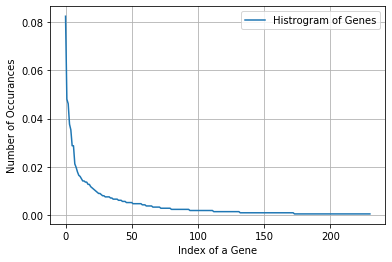

In [25]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


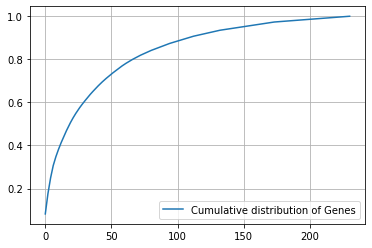

In [26]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [0]:
#response-coding of the Gene Feature
#alpha is used for laplace smoothing
alpha = 1

train_gene_feature_responsecoding = np.array(get_gv_feature(alpha,"Gene",train_df))
test_gene_feature_responsecoding = np.array(get_gv_feature(alpha,"Gene",test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [28]:
train_gene_feature_responsecoding.shape

(2124, 9)

one hot encoding


In [0]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>
**Using logistic Regression**

In [30]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1611390799654202
For values of alpha =  0.0001 The log loss is: 1.1404271565014898
For values of alpha =  0.001 The log loss is: 1.1928624748858871
For values of alpha =  0.01 The log loss is: 1.3320447837304417
For values of alpha =  0.1 The log loss is: 1.442316768748071
For values of alpha =  1 The log loss is: 1.482215395088102


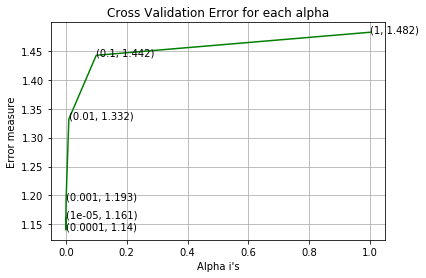

In [31]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [32]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2',loss='log', random_state=42 )
clf.fit(train_gene_feature_onehotCoding,y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding,y_train)

print("Best Alpha: - ",alpha[best_alpha])
predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print("Train log loss:-  ",log_loss(y_train,predict_y,labels=clf.classes_,eps = 1e-15))
print('-'*50)
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print("CV log loss:- ",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
print('-'*50)
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print("Test log loss:- ",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

Best Alpha: -  0.0001
Train log loss:-   1.007890930017742
--------------------------------------------------
CV log loss:-  1.1404271565014898
--------------------------------------------------
Test log loss:-  1.2113496301847437


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [33]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Test Coverage: ',test_coverage,'out of ',test_df.shape[0],' Test data')
print('CV Coverage: ',cv_coverage,'out of ',cv_df.shape[0],' CV data')

Q6. How many data points in Test and CV datasets are covered by the  231  genes in train dataset?
Test Coverage:  640 out of  665  Test data
CV Coverage:  520 out of  532  CV data


**3.2.2 Univariate Analysis on Variation Feature**

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [34]:
uniques_var = train_df['Variation'].value_counts()
print('Number of Categories: ',uniques_var.shape[0])
uniques_var.head(10)

Number of Categories:  1920


Truncating_Mutations    61
Deletion                50
Amplification           47
Fusions                 23
Overexpression           6
Q61H                     3
E17K                     3
T167A                    2
P130S                    2
R173C                    2
Name: Variation, dtype: int64

So,Variation feature have 1930 different categories.

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [0]:
# response coding:
alpha = 1
train_variation_feature_responsecoding = np.array(get_gv_feature(alpha,'Variation',train_df))
test_variation_feature_responsecoding = np.array(get_gv_feature(alpha,'Variation',test_df))
cv_variation_feature_responsecoding = np.array(get_gv_feature(alpha,'Variation',cv_df))

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

In [36]:
train_variation_feature_responsecoding.shape

(2124, 9)

In [0]:
# one hot encoding for Variation feature
var_vectorizer = CountVectorizer()
train_variation_feature_onehot = var_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehot = var_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehot = var_vectorizer.transform(cv_df['Variation'])

Logistic regression on variation feature using onehot encoding

In [38]:
alpha = [10**a for a in range(-5,1)]

cv=[]
for i in alpha:
  clf = SGDClassifier(alpha = i,penalty ='l2',loss = 'log',random_state=42)
  clf.fit(train_variation_feature_onehot, y_train)

  sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_variation_feature_onehot, y_train)
  predict_y = sig_clf.predict_proba(cv_variation_feature_onehot)

  cv.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
  print("Alpha = ",i,' then log loss for log loss: ',log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


Alpha =  1e-05  then log loss for log loss:  1.724723086802466
Alpha =  0.0001  then log loss for log loss:  1.720856648114849
Alpha =  0.001  then log loss for log loss:  1.7228715633681309
Alpha =  0.01  then log loss for log loss:  1.7360166276696416
Alpha =  0.1  then log loss for log loss:  1.7473180042989056
Alpha =  1  then log loss for log loss:  1.7474015774556968


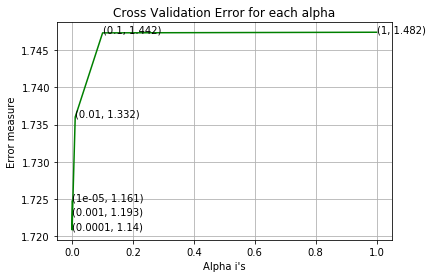

In [39]:
fig, ax = plt.subplots()
ax.plot(alpha, cv,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [40]:
best_alpha = np.argmin(cv)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehot, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehot, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7496840852361819
For values of best alpha =  0.0001 The cross validation log loss is: 1.720856648114849
For values of best alpha =  0.0001 The test log loss is: 1.7129112598492304


In [41]:
cv_log_error_array

[1.1611390799654202,
 1.1404271565014898,
 1.1928624748858871,
 1.3320447837304417,
 1.442316768748071,
 1.482215395088102]

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [42]:
print("Q12. How many data points are covered by total ", uniques_var.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1920  genes in test and cross validation data sets?
Ans
1. In test data 63 out of 665 : 9.473684210526317
2. In cross validation data 55 out of  532 : 10.338345864661653


**3.2.3 Univariate Analysis on Text Feature**

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [0]:
# we count the number of occurance of a word using dictionary
def extract_dictionary_paddle(cls_text):
  dictionary = defaultdict(int)
  for index,row in cls_text.iterrows():
    for word in row['TEXT'].split():
      dictionary [word] +=1
  return dictionary

In [0]:
# p(y=i|text) i=level in responsecoding
import math
def get_text_responsecoding(df):
  text_feature_responsecoding = np.zeros((df.shape[0],9))
  for i in range(0,9):
    row_index = 0
    for index,row in df.iterrows():
      sum_prob =0
      for word in row['TEXT'].split():
        sum_prob += math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90))) # p(y=i|text) = product(1 to i) p(y=i|Wi)=(y=1 & num of wi)/total wi
        # dict_list =[] contains 9 dictoinaries each corresponds to a class # total_dict is buid on whole training text data
      text_feature_responsecoding [row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
      row_index +=1
  return text_feature_responsecoding


In [0]:
text_vectorizer = CountVectorizer(min_df=3)

train_text_feature_onehotcoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_feature = text_vectorizer.get_feature_names()
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotcoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_feature),train_text_fea_counts))


In [46]:
train_text_fea_counts
#using A1

array([2417, 5713,    8, ...,    7,    6,   19], dtype=int64)

In [47]:
train_text_fea_counts

array([2417, 5713,    8, ...,    7,    6,   19], dtype=int64)

In [0]:
dict_list =[]
for i in range(1,10):
  cls_text = train_df[train_df['Class']==i]
  dict_list.append(extract_dictionary_paddle(cls_text))
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_feature:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [0]:
# response coding
train_text_feature_responsecoding = get_text_responsecoding(train_df)
test_text_feature_responsecoding = get_text_responsecoding(test_df)
cv_text_feature_responsecoding = get_text_responsecoding(cv_df)

In [0]:
# now we normalize responsecoding
# https://stackoverflow.com/a/16202486
train_text_feature_responsecoding =(train_text_feature_responsecoding.T/train_text_feature_responsecoding.sum(axis=1)).T
test_text_feature_responsecoding = (test_text_feature_responsecoding.T/test_text_feature_responsecoding.sum(axis=1)).T
cv_text_feature_responsecoding = (cv_text_feature_responsecoding.T/cv_text_feature_responsecoding.sum(axis=1)).T

In [0]:
# now we normalize onehotcoding
train_text_feature_onehotcoding = normalize(train_text_feature_onehotcoding,axis=0) #train_text_feature_onehotcoding is a dataframe

test_text_feature_onehotcoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotcoding = normalize(test_text_feature_onehotcoding,axis=0)

cv_text_feature_onehotcoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotcoding = normalize(cv_text_feature_onehotcoding,axis=0)

In [0]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [53]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5513, 4: 3537, 6: 2950, 5: 2560, 9: 2134, 7: 2094, 8: 1645, 10: 1520, 12: 1307, 14: 1097, 11: 970, 16: 869, 13: 809, 18: 804, 15: 777, 17: 689, 24: 562, 20: 538, 21: 533, 19: 532, 27: 444, 22: 400, 29: 369, 28: 360, 23: 352, 38: 345, 30: 343, 26: 335, 25: 334, 32: 303, 36: 293, 42: 285, 54: 279, 31: 263, 33: 240, 35: 236, 34: 224, 40: 218, 48: 211, 39: 195, 37: 192, 44: 183, 41: 183, 45: 177, 57: 173, 50: 173, 43: 170, 55: 168, 46: 165, 51: 153, 56: 148, 53: 141, 47: 139, 60: 134, 52: 128, 49: 126, 63: 124, 84: 123, 65: 120, 59: 112, 64: 109, 58: 109, 61: 107, 68: 106, 66: 106, 70: 101, 62: 101, 76: 91, 71: 91, 67: 90, 72: 89, 69: 87, 80: 86, 78: 85, 73: 84, 85: 80, 75: 80, 108: 79, 96: 79, 86: 77, 87: 73, 90: 71, 88: 71, 77: 71, 82: 70, 89: 69, 79: 66, 91: 65, 81: 64, 103: 63, 126: 62, 74: 62, 92: 61, 83: 59, 120: 55, 99: 55, 105: 54, 97: 54, 110: 52, 102: 52, 98: 51, 145: 50, 104: 49, 95: 49, 93: 49, 136: 48, 113: 48, 112: 48, 109: 47, 94: 47, 114: 46, 106: 46, 117: 45, 1

In [54]:
alpha = [10**a for a in range(-5,1)]

cv=[]
for i in alpha:
  clf = SGDClassifier(alpha = i,penalty ='l2',loss = 'log',random_state=42)
  clf.fit(train_text_feature_onehotcoding, y_train)

  sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_text_feature_onehotcoding, y_train)
  predict_y = sig_clf.predict_proba(cv_text_feature_onehotcoding)

  cv.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
  print("Alpha = ",i,' then log loss for log loss: ',log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

Alpha =  1e-05  then log loss for log loss:  1.3071962893554394
Alpha =  0.0001  then log loss for log loss:  1.1701979203579507
Alpha =  0.001  then log loss for log loss:  1.1528713805504498
Alpha =  0.01  then log loss for log loss:  1.2814235884308542
Alpha =  0.1  then log loss for log loss:  1.4048617744362315
Alpha =  1  then log loss for log loss:  1.60382419603581


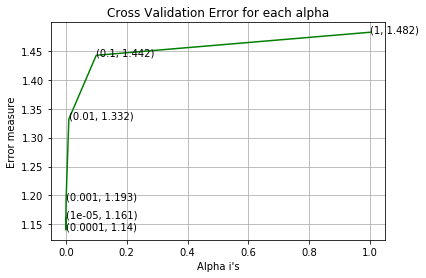

In [55]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [56]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2',loss='log', random_state=42 )
clf.fit(train_text_feature_onehotcoding,y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_text_feature_onehotcoding,y_train)

print("Best Alpha: - ",alpha[best_alpha])
predict_y = sig_clf.predict_proba(train_text_feature_onehotcoding)
print("Train log loss:-  ",log_loss(y_train,predict_y,labels=clf.classes_,eps = 1e-15))
print('-'*50)
predict_y = sig_clf.predict_proba(cv_text_feature_onehotcoding)
print("CV log loss:- ",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
print('-'*50)
predict_y = sig_clf.predict_proba(test_text_feature_onehotcoding)
print("Test log loss:- ",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

Best Alpha: -  0.0001
Train log loss:-   0.7244054275303765
--------------------------------------------------
CV log loss:-  1.1701979203579507
--------------------------------------------------
Test log loss:-  1.1919369403728217


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [0]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_feature) & set(df_text_features))
    return len1,len2

In [58]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.886 % of word of test data appeared in train data
97.584 % of word of Cross Validation appeared in train data


# **4. Machine Learning Models**

In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

**Stacking the three types of features**

In [0]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehot))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehot))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehot))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotcoding)).tocsr()
train_y = np.array(list(train_df['Class'])) #if we use train_test_split then it come as np.array...so we convert train_df['Class'] (type=class) into list->np.array.

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotcoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotcoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


In [0]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responsecoding,train_variation_feature_responsecoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responsecoding,test_variation_feature_responsecoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responsecoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responsecoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responsecoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responsecoding))

In [63]:
train_x_onehotCoding

<2124x55336 sparse matrix of type '<class 'numpy.float64'>'
	with 3335423 stored elements in Compressed Sparse Row format>

In [64]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55336)
(number of data points * number of features) in test data =  (665, 55336)
(number of data points * number of features) in cross validation data = (532, 55336)


In [65]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

In [66]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
  clf = MultinomialNB(alpha=i)
  clf.fit(train_x_onehotCoding,train_y)
  sig_clf= CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_onehotCoding,train_y)
  sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
  cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels=clf.classes_,eps=1e-15))
  print('Alpha :',i)
  print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


Alpha : 1e-05
Log Loss : 1.2201020992478613
Alpha : 0.0001
Log Loss : 1.2114840619106961
Alpha : 0.001
Log Loss : 1.2094841328116077
Alpha : 0.1
Log Loss : 1.2510671810190708
Alpha : 1
Log Loss : 1.2390966774264252
Alpha : 10
Log Loss : 1.3481867135183618
Alpha : 100
Log Loss : 1.3797767840835375
Alpha : 1000
Log Loss : 1.337476809740758


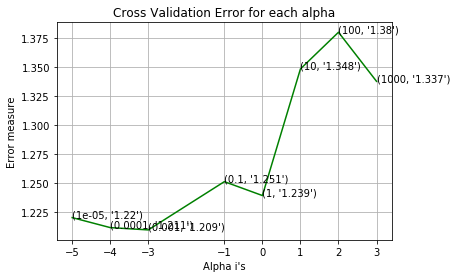

In [67]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [68]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding,train_y)
sig_clf= CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotCoding,train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.8632300587317099
For values of best alpha =  0.001 The cross validation log loss is: 1.2094841328116077
For values of best alpha =  0.001 The test log loss is: 1.3057256947113656


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.2094841328116077
Number of misclassified points:  0.3684210526315789
-------------------- Confusion matrix --------------------


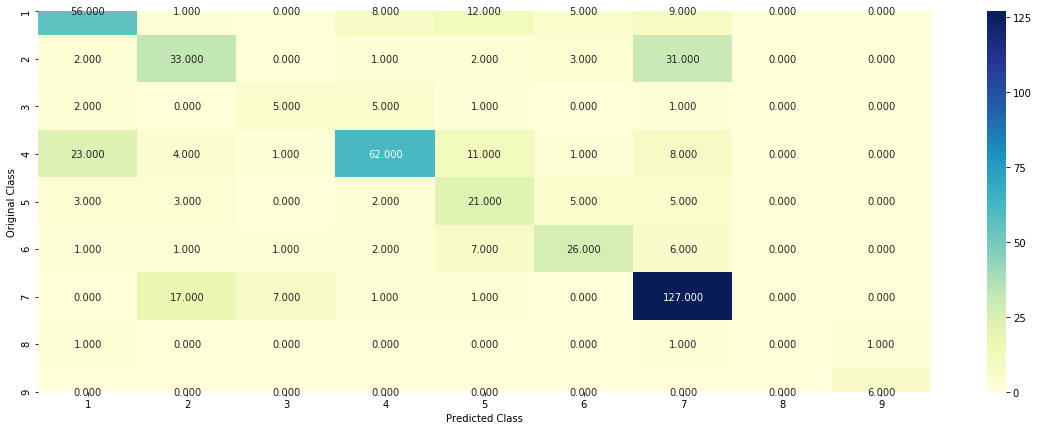

-------------------- Precision matrix (Columm Sum=1) --------------------


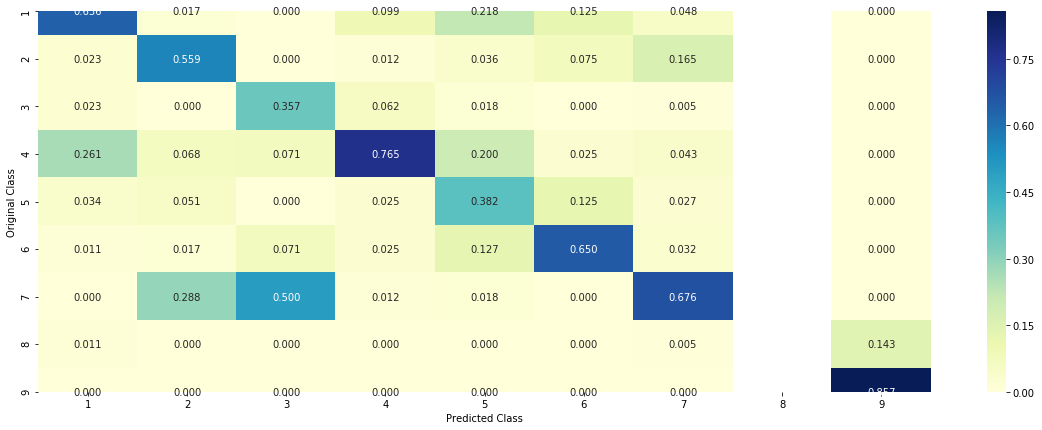

-------------------- Recall matrix (Row sum=1) --------------------


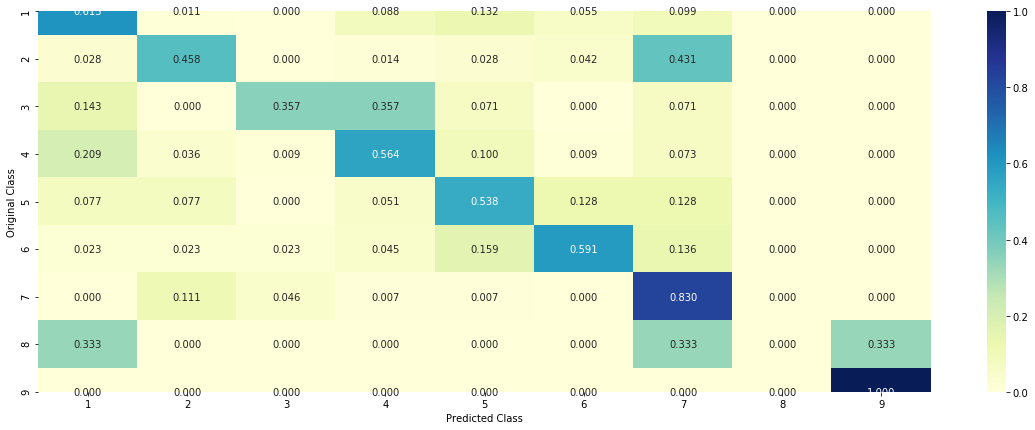

In [69]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))

#plot confusion matrix

p = sig_clf.predict(cv_x_onehotCoding)
mis = (np.count_nonzero(p-cv_y))/cv_y.shape[0]
print('Number of misclassified points: ',mis)
plot_confusion_matrix(cv_y,p)


<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0215131519310012
for alpha = 11
Log Loss : 1.0074300707793815
for alpha = 15
Log Loss : 1.0254239145177932
for alpha = 21
Log Loss : 1.0347296478774752
for alpha = 31
Log Loss : 1.051045049442062
for alpha = 41
Log Loss : 1.0678102060494798
for alpha = 51
Log Loss : 1.0803685543173285
for alpha = 99
Log Loss : 1.1192495892412089


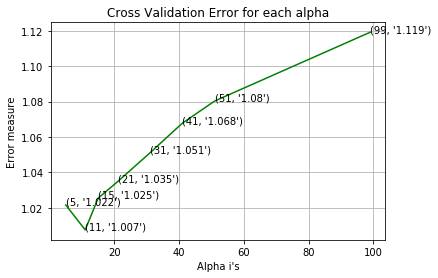

For values of best alpha =  11 The train log loss is: 0.6504485262350592
For values of best alpha =  11 The cross validation log loss is: 1.0074300707793815
For values of best alpha =  11 The test log loss is: 1.081227738822099


In [70]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.0074300707793815
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


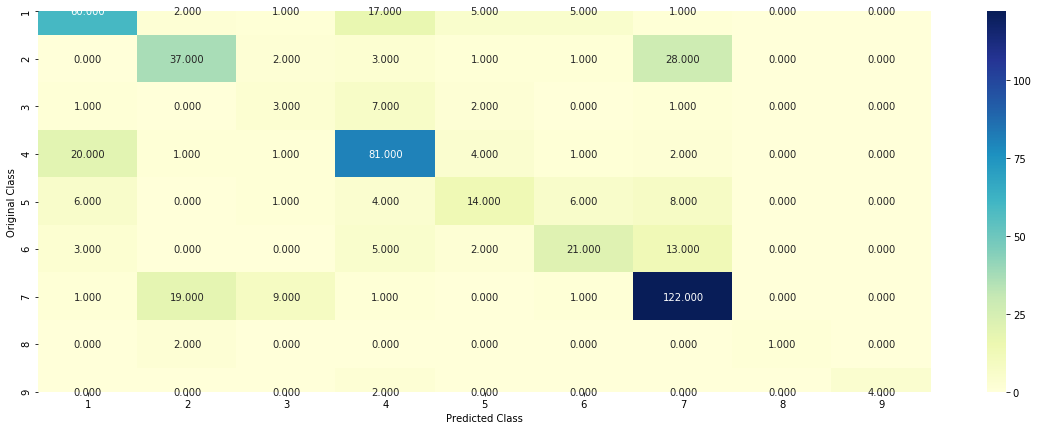

-------------------- Precision matrix (Columm Sum=1) --------------------


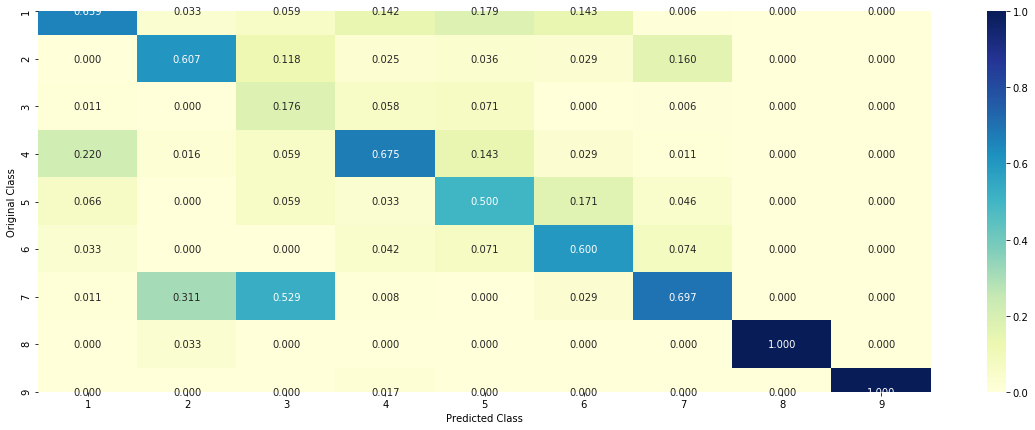

-------------------- Recall matrix (Row sum=1) --------------------


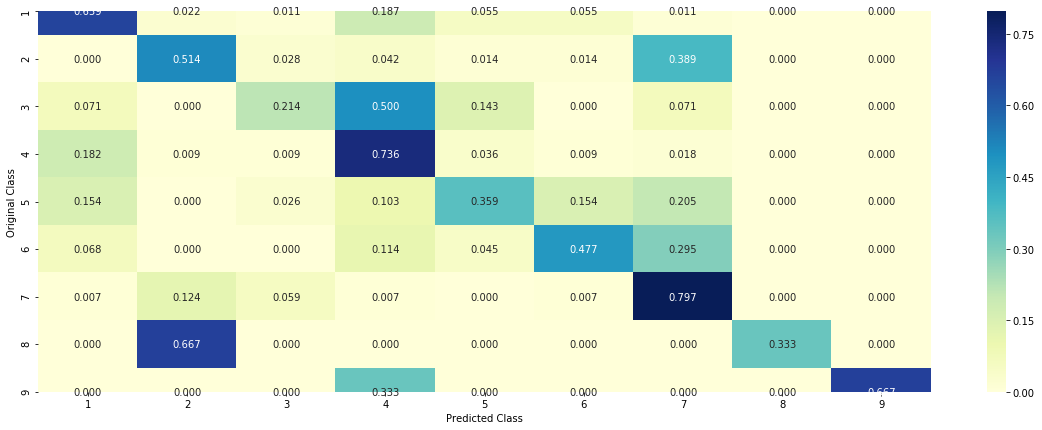

In [71]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [72]:
test_x_responseCoding[1].reshape(1,-1) # reshape is used to create test dataset with one datapoints

array([[0.1965812 , 0.08547009, 0.08547009, 0.1965812 , 0.08547009,
        0.08547009, 0.09401709, 0.08547009, 0.08547009, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.24381556, 0.09076695,
        0.02920461, 0.26921045, 0.05084784, 0.04967055, 0.24224113,
        0.00937925, 0.01486366]])

In [73]:
test_x_responseCoding[1]

array([0.1965812 , 0.08547009, 0.08547009, 0.1965812 , 0.08547009,
       0.08547009, 0.09401709, 0.08547009, 0.08547009, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.24381556, 0.09076695,
       0.02920461, 0.26921045, 0.05084784, 0.04967055, 0.24224113,
       0.00937925, 0.01486366])

In [74]:
clf = KNeighborsClassifier(n_neighbors= alpha[best_alpha])
clf.fit(train_x_responseCoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responseCoding,train_y)

index=0
predicted_cls = sig_clf.predict(test_x_responseCoding[index].reshape(1,-1))
print('Predicted Class: ',predicted_cls[index])
print('Actual class: ',test_y[index])

neighbors = clf.kneighbors(test_x_responseCoding[index].reshape(1,-1),alpha[best_alpha])
print('the',alpha[best_alpha],' best neighbors class :',train_y[neighbors[1][0]])
print('Frequency of nearest neighbors : ',Counter(train_y[neighbors[1][0]]))

Predicted Class:  4
Actual class:  1
the 11  best neighbors class : [4 4 4 4 4 4 4 4 7 4 7]
Frequency of nearest neighbors :  Counter({4: 9, 7: 2})


<h3>4.2.4. Sample Query Point-2 </h3>

In [75]:
clf = KNeighborsClassifier(n_neighbors= alpha[best_alpha])
clf.fit(train_x_responseCoding,train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responseCoding,train_y)

index=99
predicted_cls = sig_clf.predict(test_x_responseCoding[index].reshape(1,-1))
print('Predicted Class: ',predicted_cls[0])
print('Actual class: ',test_y[index])

neighbors = clf.kneighbors(test_x_responseCoding[index].reshape(1,-1),alpha[best_alpha])
print('the',alpha[best_alpha],' best neighbors class :',train_y[neighbors[1][0]])
print('Frequency of nearest neighbors : ',Counter(train_y[neighbors[1][0]]))

Predicted Class:  7
Actual class:  7
the 11  best neighbors class : [2 7 5 7 7 7 2 7 7 7 7]
Frequency of nearest neighbors :  Counter({7: 8, 2: 2, 5: 1})


In [76]:
test_df['TEXT'].iloc[index]

'fifteen rare cancer derived mutants pik3ca gene coding catalytic subunit p110 phosphatidylinositol 3 kinase pi3k examined biological biochemical properties fourteen mutants show gain function induce rapamycin sensitive oncogenic transformation chicken embryo fibroblasts constitutively activate akt tor mediated signaling show enhanced lipid kinase activity mapping mutants partial structural model p110 suggests three groups mutants defined location distinct functional domains protein hypothesize three groups induces gain pi3k function different molecular mechanism mutants c2 domain increase positive surface charge domain therefore may enhance recruitment p110 cellular membranes mutants helical domain map contiguous surface protein may affect interaction protein mutants kinase domain located near hinge activation loop may alter position mobility activation loop arbitrarily introduced mutations detectable phenotype map either interior protein positioned surface region lies opposite expose

**<h2>4.3. Logistic Regression</h2>**

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

In [77]:
alpha = [10**i for i in range(-6,3)]
cv_log_error_array = []

for i in alpha:
  clf = SGDClassifier(class_weight='balanced',loss = 'log',penalty = 'l2',alpha = i,random_state =42)
  clf.fit(train_x_responseCoding, train_y)
  sig_clf = CalibratedClassifierCV(clf,method = 'sigmoid')
  sig_clf.fit(train_x_onehotCoding,train_y)
  predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
  cv_log_error_array.append(log_loss(cv_y,predict_y,labels=clf.classes_,eps = 1e-15))
  print('Alpha :- ',i)
  print(log_loss(cv_y,predict_y,labels=clf.classes_,eps = 1e-15))

Alpha :-  1e-06
1.3314707990161199
Alpha :-  1e-05
1.3244349349134013
Alpha :-  0.0001
1.1545203524035703
Alpha :-  0.001
1.0947990613276641
Alpha :-  0.01
1.1496230739637232
Alpha :-  0.1
1.46269178400549
Alpha :-  1
1.7055877146572236
Alpha :-  10
1.7309771967775818
Alpha :-  100
1.7335350796168234


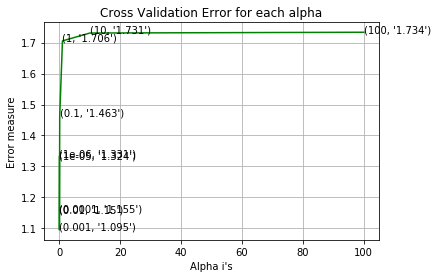

In [78]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [79]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5613765838122108
For values of best alpha =  0.001 The cross validation log loss is: 1.0947990613276641
For values of best alpha =  0.001 The test log loss is: 1.096392454308866


<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.0947990613276641
Number of mis-classified points : 0.33270676691729323
-------------------- Confusion matrix --------------------


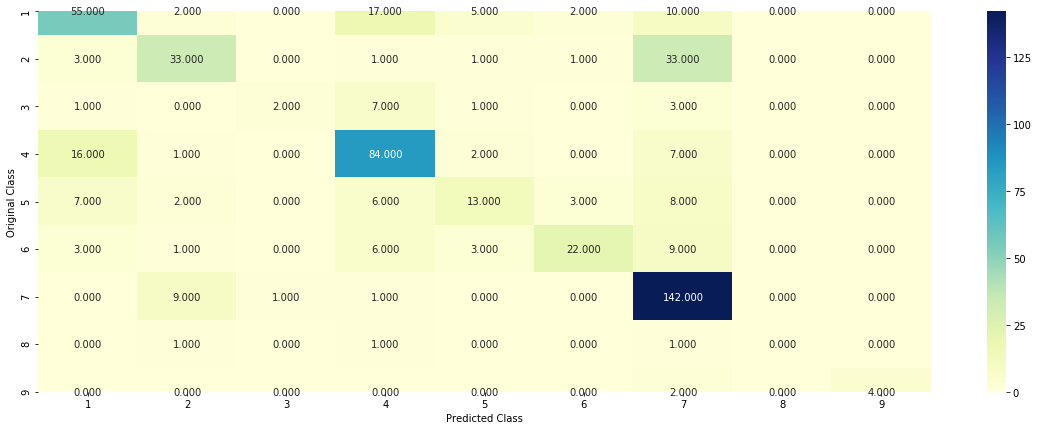

-------------------- Precision matrix (Columm Sum=1) --------------------


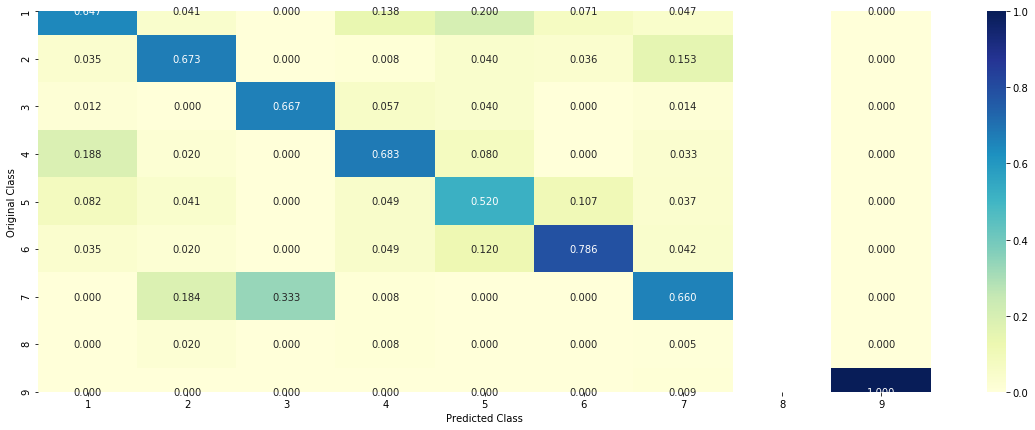

-------------------- Recall matrix (Row sum=1) --------------------


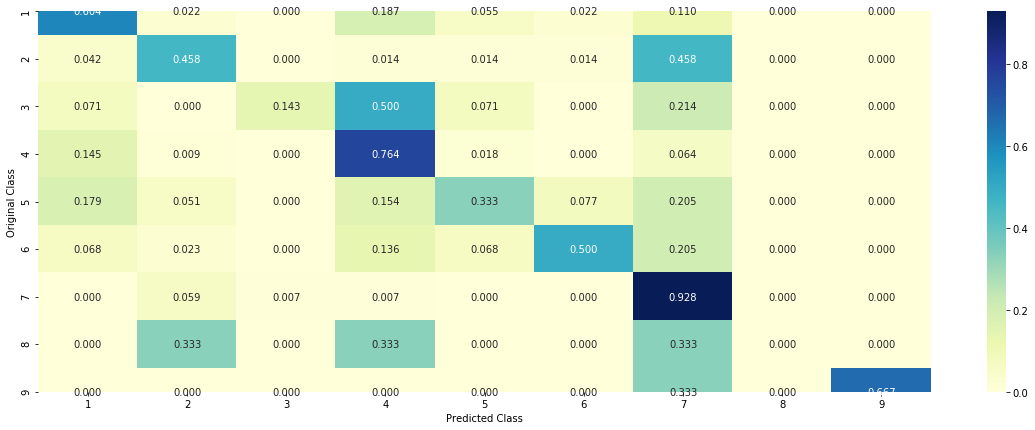

In [80]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [81]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.6651 0.0067 0.0025 0.2864 0.0076 0.0037 0.0193 0.0053 0.0034]]
Actual Class : 1


In [82]:
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
indices

array([[  718,   547,   907,  1204,  1250,  1128, 47906,  3413,   535,
        52288, 49064, 47468, 22353,   789,  1021,   709, 41483,  2027,
          674,  3180, 33759, 24343, 36054, 11526, 35940, 32385, 48705,
         3710, 34540, 47035, 12368, 41703,  3096, 34557,   665, 54606,
        52587, 20579, 50450,  1104, 54111, 44561, 53602, 15578, 30556,
        15576,  5081, 10793, 15577, 18674, 13270, 12448, 22089, 40035,
        51814,  2799, 10784, 27425,  5079,  5384, 26665, 51819, 39132,
         5614,  5604, 21600, 34730, 24473, 21601,  4133, 12503, 39316,
        23967, 50008,   797, 44282, 48598,  2222, 37070, 48780, 50304,
          423, 53628, 50725,   395,   240, 43201, 40924,  8374, 17781,
        36411, 45542, 33435, 34838, 27536, 24073, 34560, 33693, 40549,
        21785, 45194, 28027,  9903, 23569,   405, 24347, 53719, 44118,
        43206, 43203,  6090, 12005, 22581, 29761, 31926, 43205,  6115,
        43204, 17461, 17453, 17460, 16046, 17454, 17459,  6088, 31146,
      

In [83]:
test_df

,ID,Gene,Variation,Class,TEXT
2404,2404,NF1,R2450*,1,cancer therapy arguably entered transformation...
1016,1016,TSC2,L1584R,1,tuberous sclerosis complex tsc autosomal domin...
1385,1385,FGFR1,FGFR1-TACC1_Fusion,7,null abstract prospective clinical sequencing ...
2216,2216,PTEN,D92E,4,pten phosphatase tensin homolog phosphatase un...
1257,1257,PIK3R1,X582_splice,1,class ia phosphatidylinositol 3 kinases pi3k g...
...,...,...,...,...,...
1929,1929,SMO,F460L,7,basal activities adenylate cyclase guanylate c...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
142,142,EGFR,G719A,7,purpose clinical features epidermal growth fac...
1026,1026,TSC2,R905W,4,report clinical manifestations functional aspe...


**<h2>4.5 Random Forest Classifier</h2>**

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [84]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2194271013481197
for n_estimators = 100 and max depth =  10
Log Loss : 1.1602675242604352
for n_estimators = 200 and max depth =  5
Log Loss : 1.2242410386366636
for n_estimators = 200 and max depth =  10
Log Loss : 1.154452485460764
for n_estimators = 500 and max depth =  5
Log Loss : 1.2224128248287474
for n_estimators = 500 and max depth =  10
Log Loss : 1.1529804577700797
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2171724638631245
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1498739487190008
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2167785874204766
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1499505587023606
For values of best estimator =  1000 The train log loss is: 0.7043608926285652
For values of best estimator =  1000 The cross validation log loss is: 1.1498739487190008
For values of best estimator =  1000 The test log loss is: 1.1573846892988582


Log loss : 1.1498739487190008
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


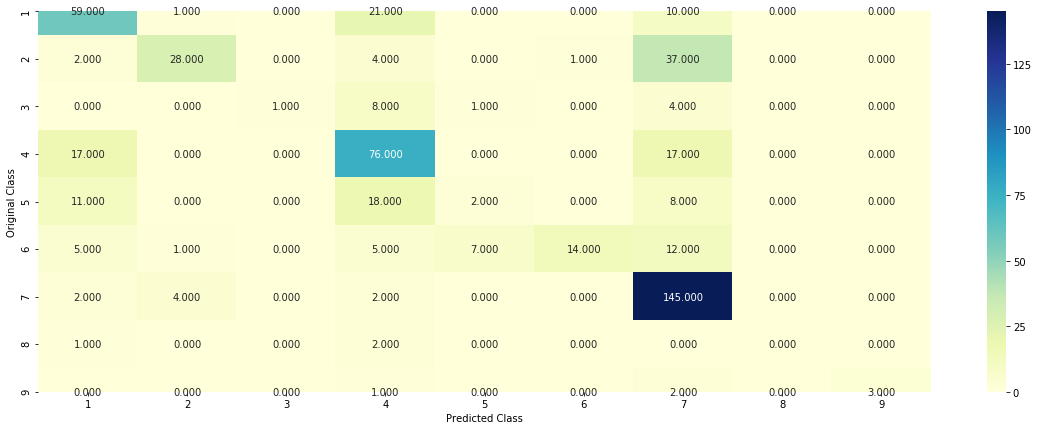

-------------------- Precision matrix (Columm Sum=1) --------------------


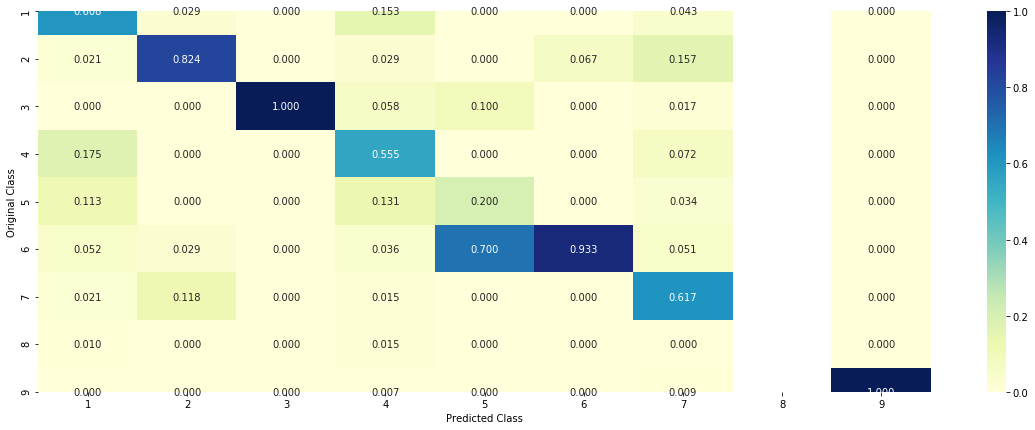

-------------------- Recall matrix (Row sum=1) --------------------


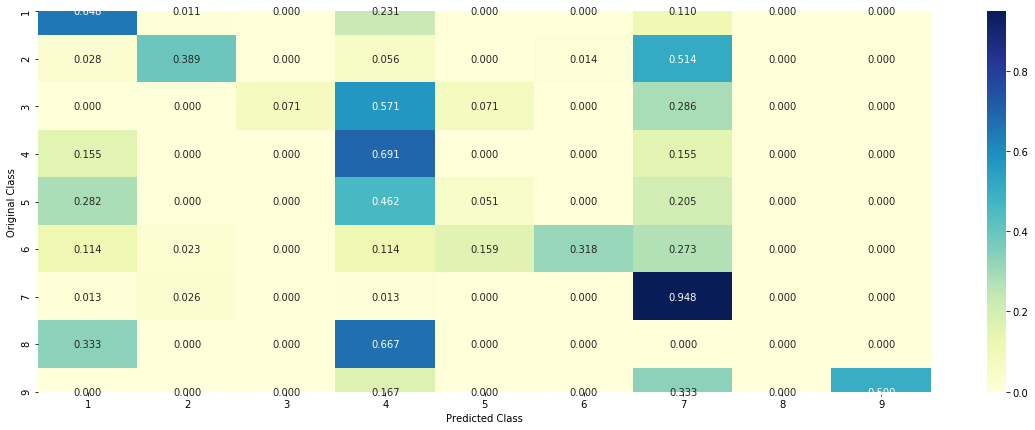

In [85]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [86]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4744 0.0319 0.0175 0.3215 0.0471 0.0415 0.0545 0.005  0.0065]]
Actual Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [activating] present in test data point [True]
4 Text feature [missense] present in test data point [True]
5 Text feature [activation] present in test data point [True]
9 Text feature [phosphorylation] present in test data point [True]
13 Text feature [signaling] present in test data point [True]
15 Text feature [function] present in test data point [True]
17 Text feature [constitutive] present in test data point [True]
22 Text feature [unstable] present in test data point [True]
27 Text feature [downstream] present in test data point [True]
29 Text feature [inhibitor] present in test data point [True]
30 Text feature [variants] present in test data point [True]
35 Text feature [stability] present in test data point [True]
39 Text 

<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [87]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.079255838038191
for n_estimators = 10 and max depth =  3
Log Loss : 1.5835833572537348
for n_estimators = 10 and max depth =  5
Log Loss : 1.5866437629675085
for n_estimators = 10 and max depth =  10
Log Loss : 2.068164709588592
for n_estimators = 50 and max depth =  2
Log Loss : 1.76357100002999
for n_estimators = 50 and max depth =  3
Log Loss : 1.4899083691673536
for n_estimators = 50 and max depth =  5
Log Loss : 1.4055183011188013
for n_estimators = 50 and max depth =  10
Log Loss : 1.8040016093351674
for n_estimators = 100 and max depth =  2
Log Loss : 1.607144389952362
for n_estimators = 100 and max depth =  3
Log Loss : 1.5581706855197504
for n_estimators = 100 and max depth =  5
Log Loss : 1.3793945427134842
for n_estimators = 100 and max depth =  10
Log Loss : 1.8157143489876655
for n_estimators = 200 and max depth =  2
Log Loss : 1.6608145759883908
for n_estimators = 200 and max depth =  3
Log Loss : 1.5376771311007171
fo

Log loss : 1.3793945427134842
Number of mis-classified points : 0.5206766917293233
-------------------- Confusion matrix --------------------


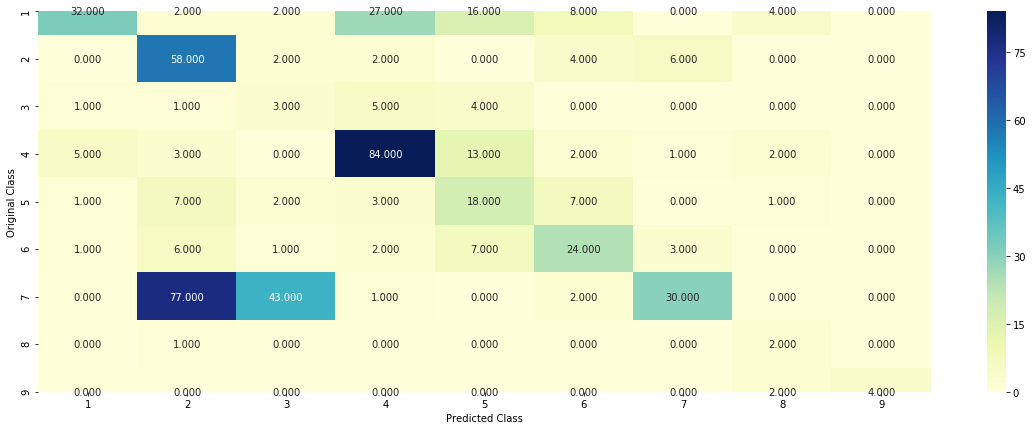

-------------------- Precision matrix (Columm Sum=1) --------------------


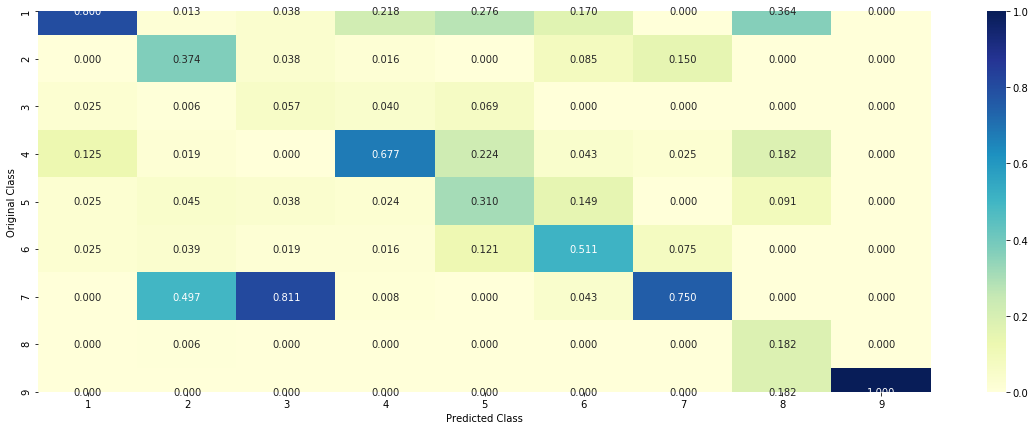

-------------------- Recall matrix (Row sum=1) --------------------


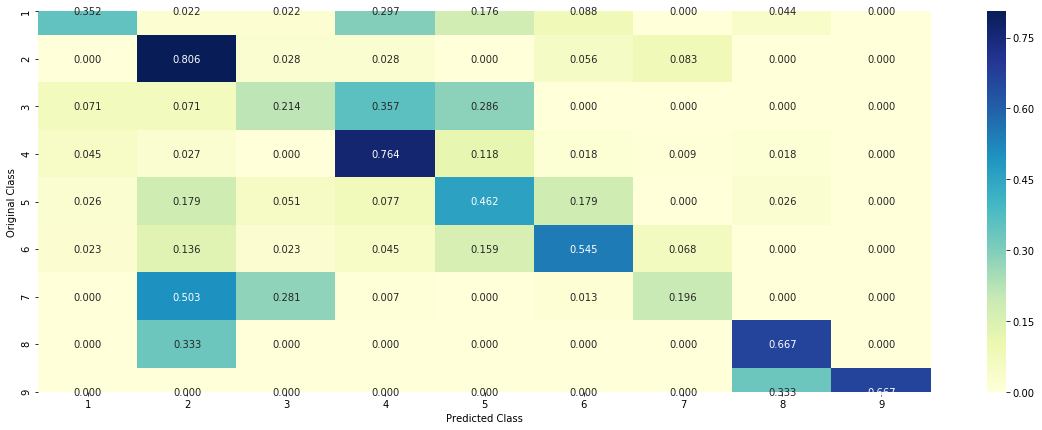

In [88]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

<h3>4.5.5. Feature Importance</h3>

In [89]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.2928 0.0168 0.1139 0.4415 0.0301 0.0609 0.0083 0.0143 0.0215]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [91]:
indices = np.argsort(-clf.feature_importances_)
print(indices)

[15 12  9 10  6 14 13 24  3 21 19 18 23 11  1  0 22  5  4 26 17 16 20 25
  2  8  7]


# **4.7 Stack the models**

In [92]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

Logistic Regression :  Log Loss: 1.09
Support vector machines : Log Loss: 1.73
Naive Bayes : Log Loss: 1.21


In [93]:
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.034
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.501
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.073
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.118
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.382


Log loss (train) on the stacking classifier : 0.6396000616137469
Log loss (CV) on the stacking classifier : 1.0732798613709935
Log loss (test) on the stacking classifier : 1.1668997443803224
Number of missclassified point : 0.3744360902255639
-------------------- Confusion matrix --------------------


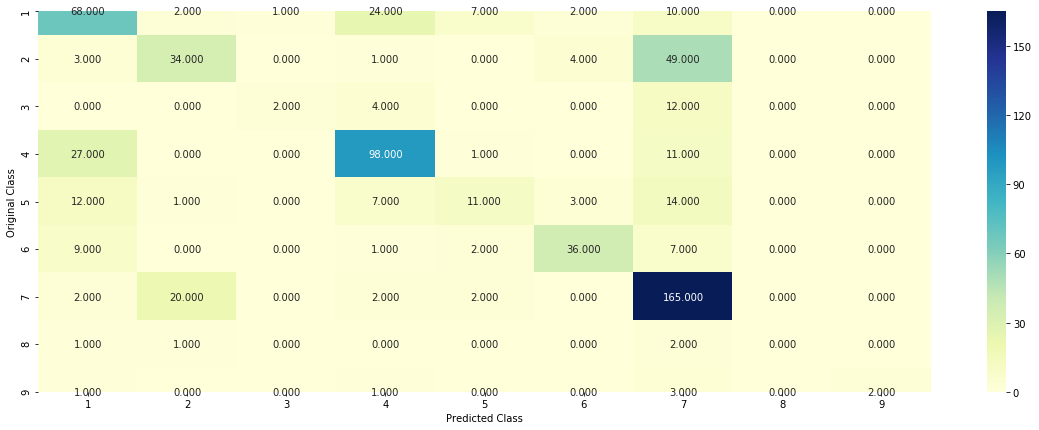

-------------------- Precision matrix (Columm Sum=1) --------------------


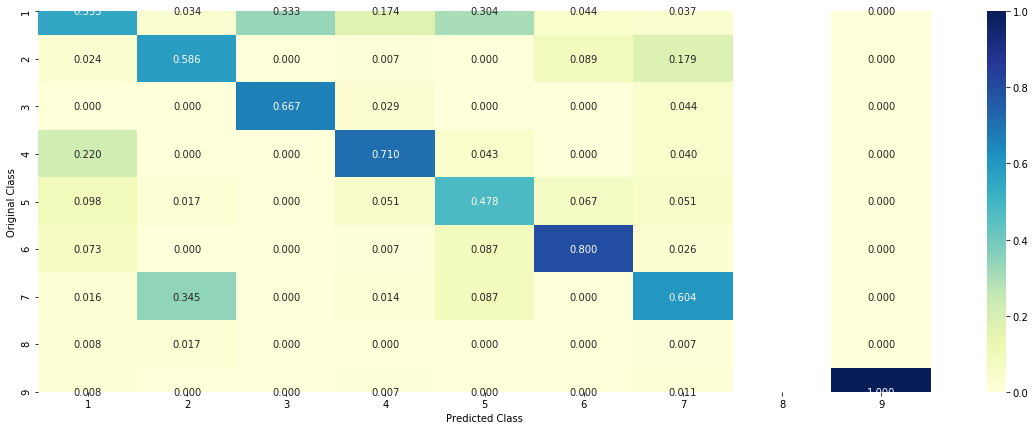

-------------------- Recall matrix (Row sum=1) --------------------


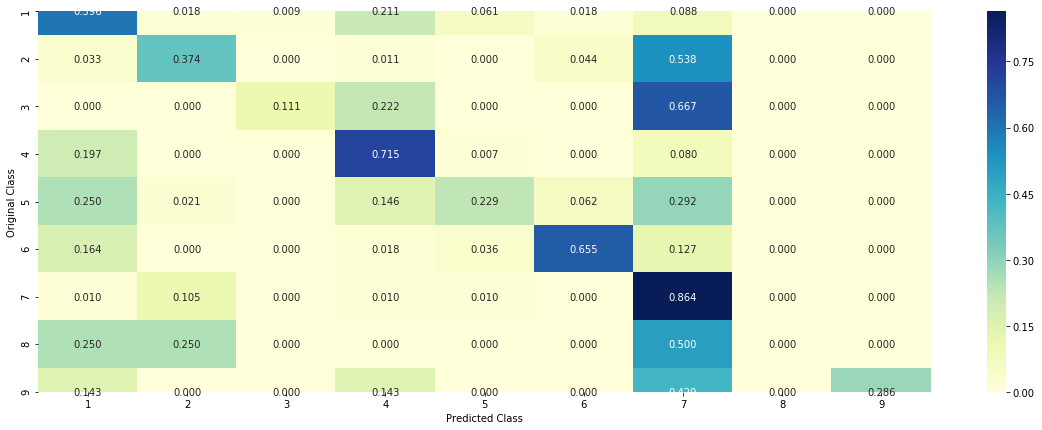

In [94]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>4.7.3 Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8946091913533838
Log loss (CV) on the VotingClassifier : 1.165794022604785
Log loss (test) on the VotingClassifier : 1.2076771722272914
Number of missclassified point : 0.3924812030075188
-------------------- Confusion matrix --------------------


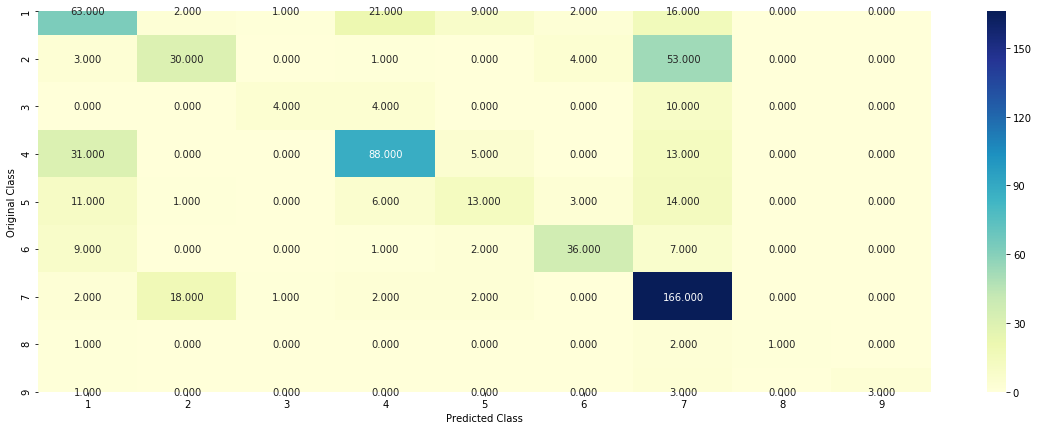

-------------------- Precision matrix (Columm Sum=1) --------------------


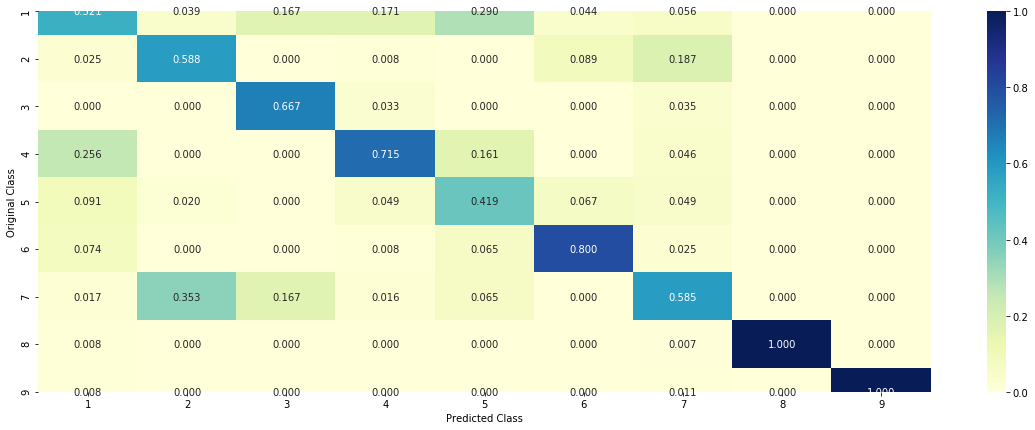

-------------------- Recall matrix (Row sum=1) --------------------


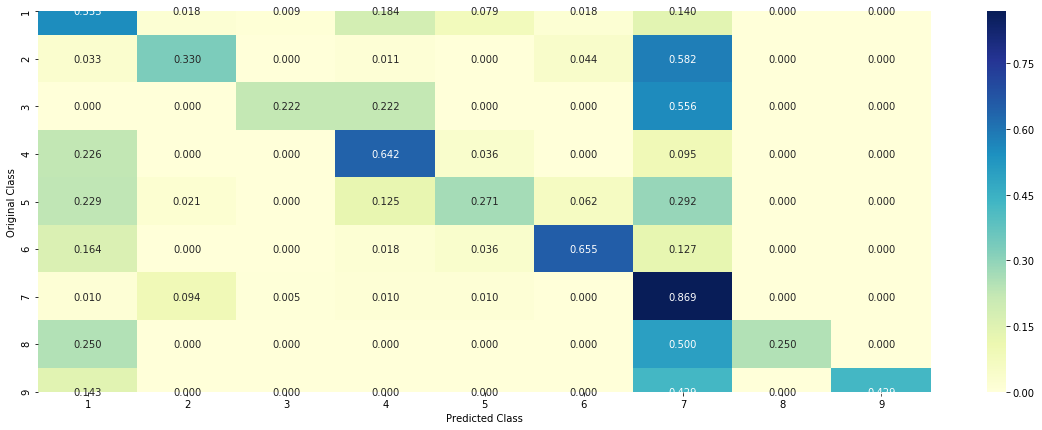

In [95]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))